In [8]:
import numpy as np 
from collections import defaultdict
from IPython.display import clear_output
from itertools import combinations
import seaborn as sns
from sklearn.manifold import LocallyLinearEmbedding, Isomap, SpectralEmbedding
from sklearn.decomposition import PCA
import pandas as pd
from itertools import combinations
from tqdm import tqdm_notebook

from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, r2_score
from sklearn.linear_model import Ridge, Lasso
r2_scorer = make_scorer(r2_score)

from utils import shuffle, similarity_metric

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Load data

In [ ]:
calcium_df = pd.read_csv(f"./data/{track}/data/CA1_{mouse}_{day}D_initial_data.csv", index_col=0)
spikes_df = pd.read_csv(f"./data/{track}/spikes/CA1_{mouse}_{day}D_initial_data_spikes.csv", index_col=0)
rears_events = pd.read_csv(f'./data/CA1_22-25_rears/CA1_{mouse}_{day}D_rears_from_npz.csv', index_col=0)

cadata = calcium_df.iloc[:,7:][trim0:-trim1].T.values # [n_neurons, T] 
spdata = spikes_df.iloc[:,1:][trim0:-trim1].T.values # [n_neurons, T]
rears_events = rears_events[trim0:-trim1]

rear_times = rears_events['time_s'].values
rears_indicators = rears_events['rear_1_outward_-1_inward'].values

cells_with_spikes = np.sum(spdata, axis = 1) > 1.
spdata = spdata[cells_with_spikes]
cadata = cadata[cells_with_spikes]

N, T = spdata.shape

coords = calcium_df[['x','y']][trim0:-trim1].values
coords -= coords.mean(0)[None,:]
minmax_scaler = MinMaxScaler((-1,1))
coords_ = minmax_scaler.fit_transform(coords)

phi = np.arctan2(coords_[:,1], coords_[:,0])
phi[phi < 0] = 2*np.pi + phi[phi < 0]

# # speed sign
dphi = np.diff(phi, prepend=phi[0])
jump_mask = np.abs(dphi) > 6 # jump through breakpoint
dphi[jump_mask] = -1 * np.sign(dphi[jump_mask]) * np.abs(dphi[jump_mask] - 2*np.pi)
circle_sign = np.sign(dphi)

# speed
shift = np.diff(coords_, prepend=[coords_[0]], axis=0)
speed = np.sqrt((shift**2).sum(1)) * circle_sign

# acceleration
acceleration = np.diff(speed, prepend=speed[0])

acceleration_ = MinMaxScaler((0,1)).fit_transform(acceleration[:,None]).flatten()
speed_ = MinMaxScaler((-1,1)).fit_transform(speed[:,None]).flatten()

rears_indicators_abs = np.pad(np.abs(rears_indicators), pad_width=(T - rears_indicators.shape[0])//2)
phi_ = MinMaxScaler().fit_transform(phi[:,None]).flatten()

targets = {
    'x': coords_[:,0],
    'y': coords_[:,1],
    'v': speed_,
    'a': acceleration_,
    'phi': phi_
}




In [10]:
X_neural = spikes_df.iloc[:,7:].to_numpy()
X_neural_std = StandardScaler().fit_transform(X_neural)
time = spikes_df['time_s'].values
N = len(time)
n_neurons = X_neural.shape[1]
events = spikes_events_df.values[:,1:].astype(bool)

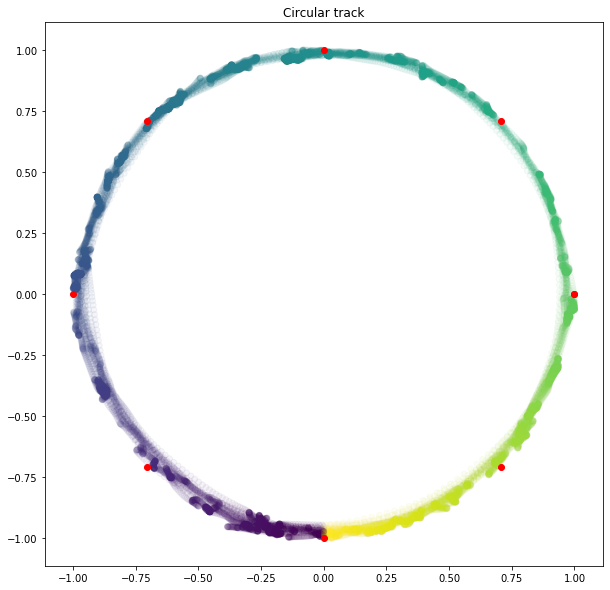

In [11]:
X = spikes_df["x"].to_numpy()
Y = spikes_df["y"].to_numpy()
X_green = spikes_df["x_green"].to_numpy()
Y_green = spikes_df["y_green"].to_numpy()
X_red = spikes_df["x_red"].to_numpy()
Y_red = spikes_df["y_red"].to_numpy()

coords = spikes_df[['x', 'y']].values
coords -= coords.mean(0)[None,:]
minmax_scaler = MinMaxScaler((-1,1))
coords_ = minmax_scaler.fit_transform(coords)
phi = np.arctan2(coords_[:,0], coords_[:,1]) + np.pi

N_places = 8
linspace = np.linspace(phi.min(), phi.max(), N_places+1)

linspace_X = np.cos(linspace)
linspace_Y = np.sin(linspace)

plt.figure(figsize=(10,10))
plt.title("Circular track")
plt.scatter(coords_[:,0], coords_[:,1], alpha=0.05, c=phi)
plt.scatter(linspace_X, linspace_Y, c='red', alpha=1)

plt.show()

# Extract place-related data

In [7]:
place2data = defaultdict(dict)
place_indexes = np.zeros(N)
for i in range(N_places):
    
    X_1 = min(linspace_X[i], linspace_X[i+1])
    X_2 = max(linspace_X[i], linspace_X[i+1])
    Y_1 = min(linspace_Y[i], linspace_Y[i+1])
    Y_2 = max(linspace_Y[i], linspace_Y[i+1]) 
    
    mask = (coords_[:,0] > X_1) * (coords_[:,0] < X_2 ) * (coords_[:,1] > Y_1) * (coords_[:,1] < Y_2) 
    
    place2data[i]['data'] = X_neural_std[mask] # activity
    place2data[i]['time'] = time[mask] # global time
    place2data[i]['coords'] = coords_[mask]

    place_indexes[mask] = i

In [8]:
# fig, axes = plt.subplots(ncols=N_places//2, nrows=2, figsize=(5*N_places//2, 10))
# for i,ax in zip(range(N_places), axes.flatten()):
#     place_mask = place_indexes == i
#     total_place_activity = events[place_mask].sum(0)
#     total_nonplace_activity = events[~place_mask].sum(0)

#     selective_neurons = total_nonplace_activity.argsort()[:50]
#     most_active_index = total_place_activity[selective_neurons].argsort()[-1]
#     activity = total_place_activity[selective_neurons][most_active_index]
#     selective_active_neuron = selective_neurons[most_active_index]
    
#     mask = events[:,selective_active_neuron]
#     if mask.any():
#         times = MinMaxScaler().fit_transform(time[mask][:,None])
#         ax.scatter(coords_[:,0][mask], coords_[:,1][mask], c=times)
#         ax.set_ylim(-1.1,1.1)
#         ax.set_xlim(-1.1,1.1)
#         ax.set_title(f'Total in-place actiations: {activity}')
# plt.show()

# Analyze rears

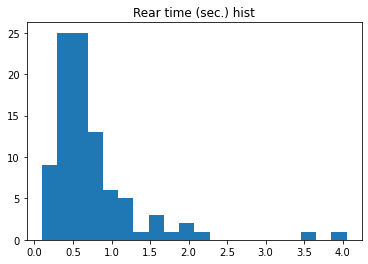

In [9]:
assert track == 'Circle'
rears_events = pd.read_csv(f'./data/CA1_22-25_rears/CA1_{mouse}_{day}D_rears_from_npz.csv', index_col=0)
rears_events = rears_events[trim:-trim]

rear_times = rears_events['time_s'].values
rears_indicators = rears_events['rear_1_outward_-1_inward'].values

rear_iterval_lengths = []
rear_intervals = []
rear_intervals_indexes = []

i = 0
while i < len(rears_indicators):
    l = 0
    while rears_indicators[i] != 0.:
        l += 1
        i += 1
    if l > 0:
        rear_iterval_lengths.append(l/20.)
        rear_intervals.append([rear_times[i-l-1], rear_times[i-1]])
        rear_intervals_indexes.append([i-l-1, i-1])
        assert np.isclose(rear_iterval_lengths[-1], abs(rear_intervals[-1][0] - rear_intervals[-1][1]))
    i += 1
    
rear_intervals = np.array(rear_intervals)
rear_iterval_lengths = np.array(rear_iterval_lengths)

plt.hist(rear_iterval_lengths, bins=20)
plt.title('Rear time (sec.) hist')
plt.show()

## Rears: where

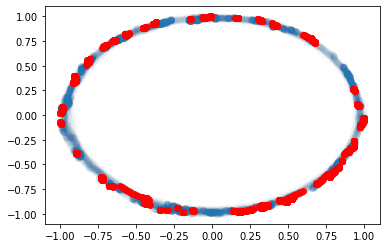

In [10]:
plt.scatter(coords_[:,0], coords_[:,1], alpha=0.01)
rears_activities = []
for interval in rear_intervals:
    t1,t2 = interval
    interval_mask = (time >= t1)*(time <= t2)
    rears_activities.append(X_neural_std[interval_mask])
    plt.scatter(coords_[:,0][interval_mask], coords_[:,1][interval_mask], color='r', alpha=0.9)

In [11]:
longest_rears_ind = np.argsort(rear_iterval_lengths)[-20:]
rear_iterval_lengths[longest_rears_ind]

array([0.9 , 0.95, 1.  , 1.05, 1.05, 1.1 , 1.1 , 1.1 , 1.15, 1.15, 1.45,
       1.5 , 1.55, 1.65, 1.8 , 2.05, 2.05, 2.15, 3.6 , 4.05])

In [12]:
# splits = np.linspace(0,N-1, 4).astype(int)
# n_components = 10
# n_vis = 3
# for i in range(len(splits)-1):
    
#     s1,s2 = splits[i], splits[i+1]
#     t1,t2 = time[s1], time[s2]
    
#     lem = SpectralEmbedding(n_components=n_components, n_neighbors=250, random_state=42)
#     lem_emb = lem.fit_transform(X_neural_std[s1:s2])

#     model = MultiOutputRegressor(Ridge())
#     data_numpy_shuffled, coords_shuffled = shuffle(X_neural_std[s1:s2], coords_[s1:s2])
#     r2 = cross_val_score(model, data_numpy_shuffled, coords_shuffled, cv=5, verbose=False, scoring=r2_scorer).mean()

# #     dims_combinations = list(combinations(np.arange(n_components), 2))
# #     np.random.shuffle(dims_combinations)
# #     fig, axes = plt.subplots(ncols=n_vis, nrows=1, figsize=(n_vis*5,5))
#     d1,d2 = 0,1
#     plt.scatter(lem_emb[:,d1], lem_emb[:,d2], alpha=0.1, c=phi[s1:s2])
#     plt.title(f'TIME: {t1}-{t2}, DIMS: {d1},{d2} \n coords R2 score: {r2}')
#     plt.tight_layout()
#     plt.show()

# How activity change in the certain place with time
### TODO
 - merge small arriving-departure parts into one (with small time discrepancy)
 - check in-place-activity clusterization
 - check preceding-place-activity embedding and clusterization
 - choose places with lowest transitions between them 


In [13]:
def get_place_preceding_activity(X, data, delta = 10):
    '''
    delta - minimum time-space between visiting area
    result - in-place activity
    result_time - [arrival, departure]
    previous_departure
    '''
    result = defaultdict(list)
    N_i = len(data['time'])
    shift_mask = np.diff(data['time']) > delta
    j_prev = 0
    for j,is_jump in enumerate(shift_mask):
        if is_jump:
            result['data_inplace'].append(data['data'][j_prev:j])
            result['coords_inplace'].append(data['coords'][j_prev:j])
            # take after-jump time
            arrival_time = data['time'][j_prev]
            # take before-jump time
            previous_departure_time = data['time'][j_prev-1] if j_prev > 0 else 0 
            transition_time = (time < arrival_time)*(previous_departure_time < time)
            if transition_time.any():
                result['data_transition'].append(X[transition_time])
            else:
                result['data_transition'].append(None)
            j_prev = j+1
            
    return result

# In-place regression

In [19]:
dataset_per_visit = {}
place_activity = {}
for place_number in range(N_places):
    place_activity[place_number] = get_place_preceding_activity(X_neural_std, place2data[place_number], delta = 10)

In [20]:
place2visits_number = {k:len(v['data_inplace']) for k,v in place_activity.items()}

In [21]:
place2visits_number.values()

dict_values([10, 10, 12, 14, 14, 13, 14, 12])

In [27]:
# V_all_time = similarity_metric(X_neural_std, X_neural_std)
# V_all_time_holes = similarity_metric(X_neural_std_holes, X_neural_std_holes)

In [26]:
# start, end = 3000, 8000
# plt.figure(figsize=(20,20))
# V_all_trunc = V_all_time[start:end, start:end]
# plt.imshow(V_all_trunc)
# for rear_interval_ind in rear_intervals_indexes:
#     r1, r2 = rear_interval_ind
#     if (r1 > start) and (r2 < end):
#         plt.fill_between(np.arange(V_all_trunc.shape[0]),
#                         r1 - start,
#                         r2 - start,
#                         color='r',
#                         alpha=0.3)
# plt.show()

In [29]:
# fig, ax = plt.subplots(ncols=2, nrows=1,figsize=(20,10))
# ax[0].imshow(V_all_time)
# ax[0].set_title('Circle')
# ax[1].imshow(V_all_time_holes)
# ax[1].set_title('Holes')

# plt.show()

# In-place activations

In [42]:
result = place_activity[3]

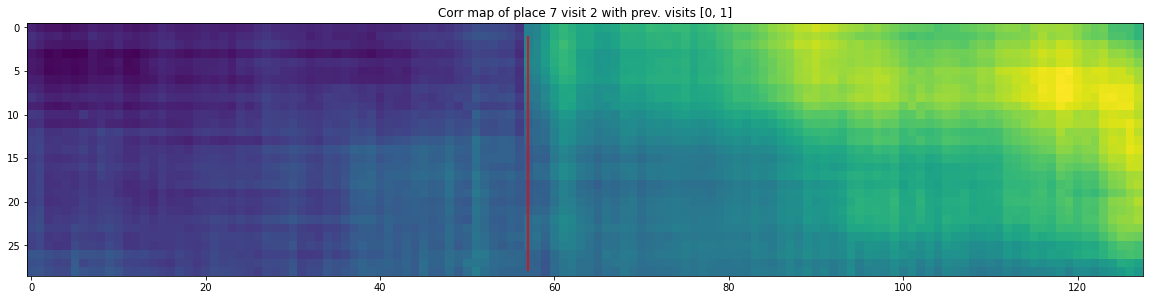

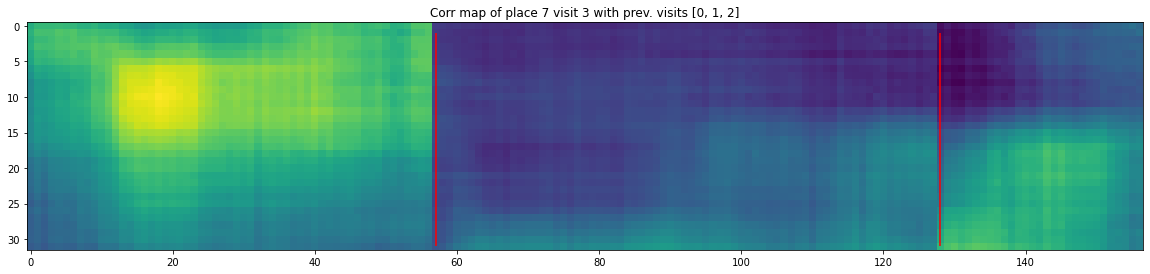

ValueError: 'box_aspect' and 'fig_aspect' must be positive

<Figure size 1440x0 with 1 Axes>

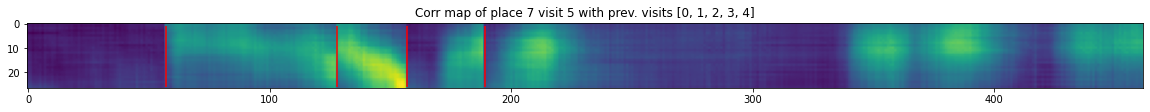

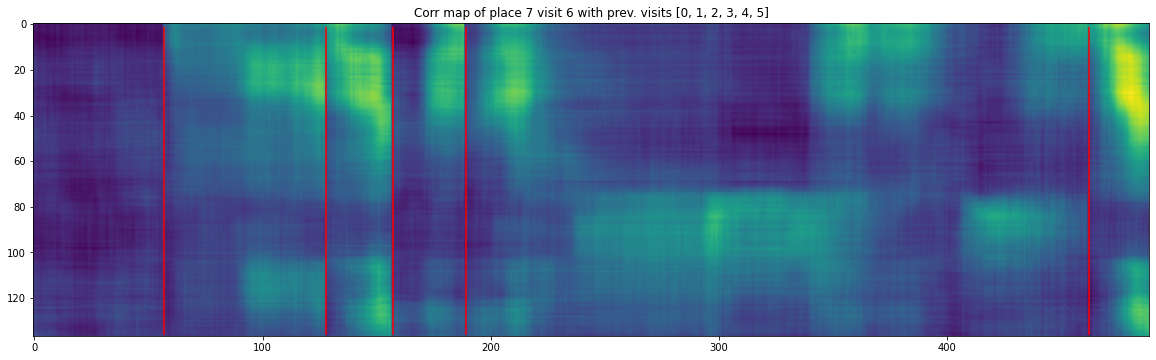

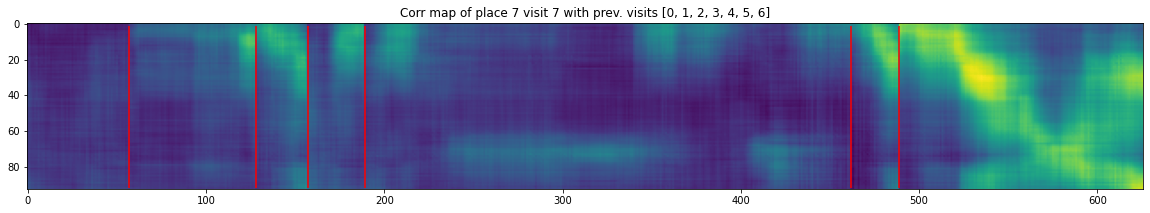

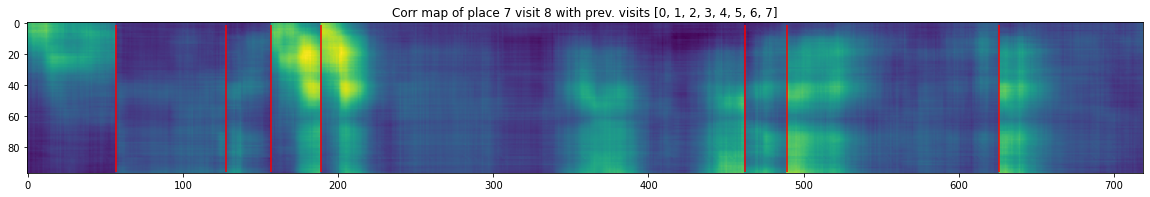

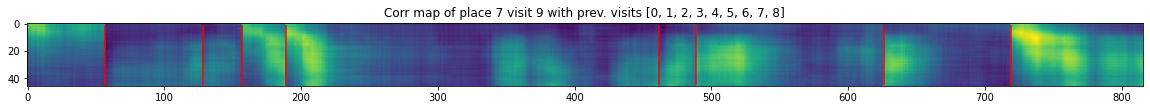

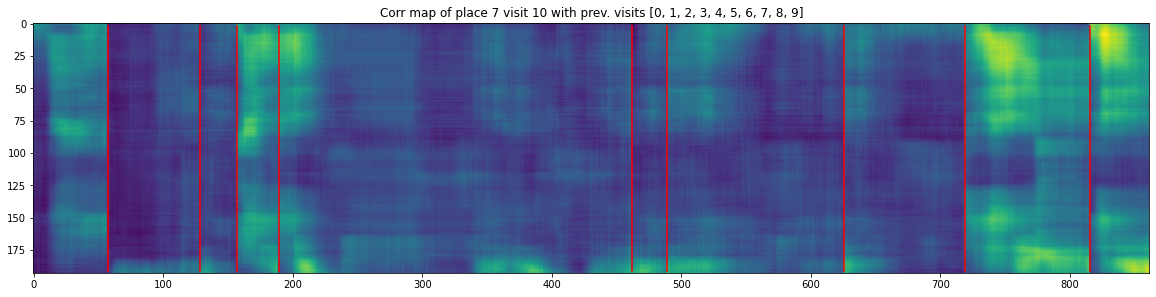

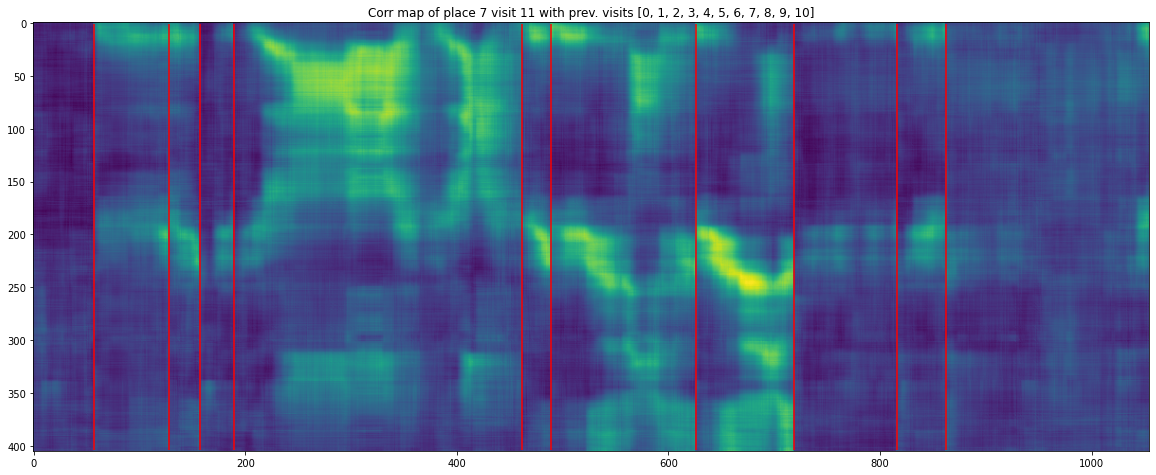

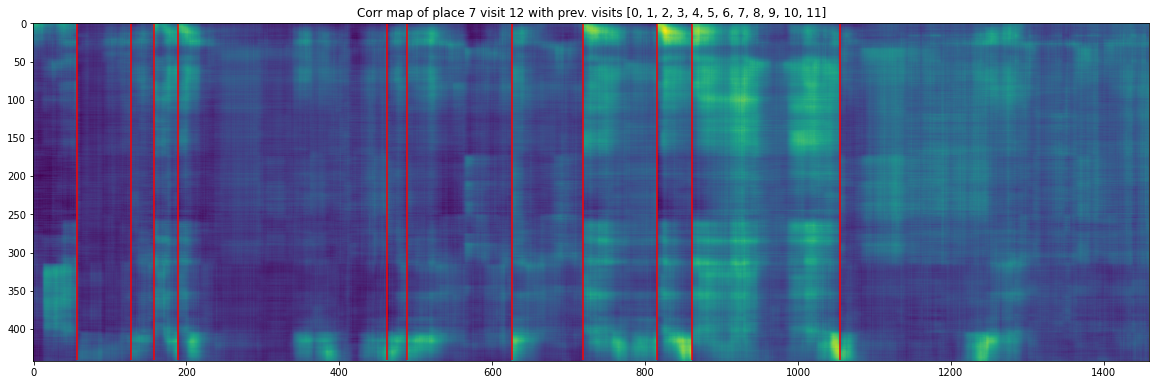

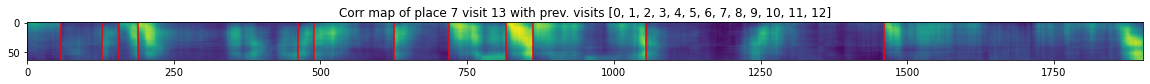

In [44]:
n_inplace = len(result['data_inplace'])
for i in range(n_inplace):
    if i > 1:
        V_s = []
        for j in range(i):
            x1 = result['data_inplace'][i]
            x2 = result['data_inplace'][j]
            V = similarity_metric(x1,x2)
            V_s.append(V)
        V_all = np.concatenate(V_s, 1)
        h,w = V_all.shape
        plt.figure(figsize=(20,20*(w//h)))
        plt.imshow(V_all)
        plt.vlines(x=np.cumsum([V.shape[1] for V in V_s][:-1]),
                  ymin=1,
                  ymax=V_all.shape[0]-1,
                  color='r')
        plt.title(f'Corr map of place {place_number} visit {i} with prev. visits {list(range(i))}')
plt.show()

# Transition activities correlation

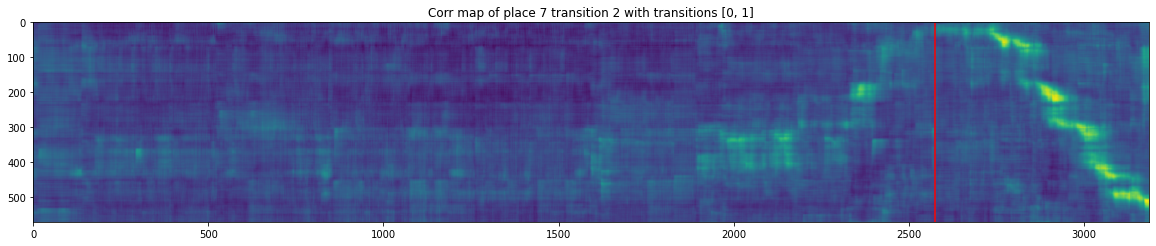

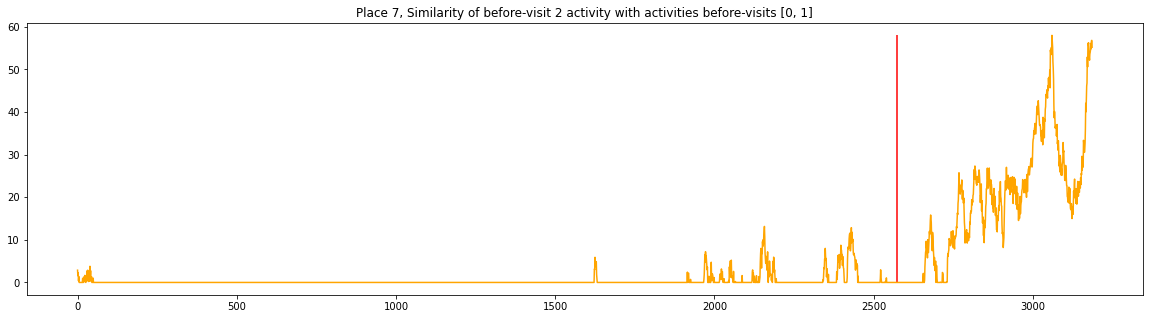

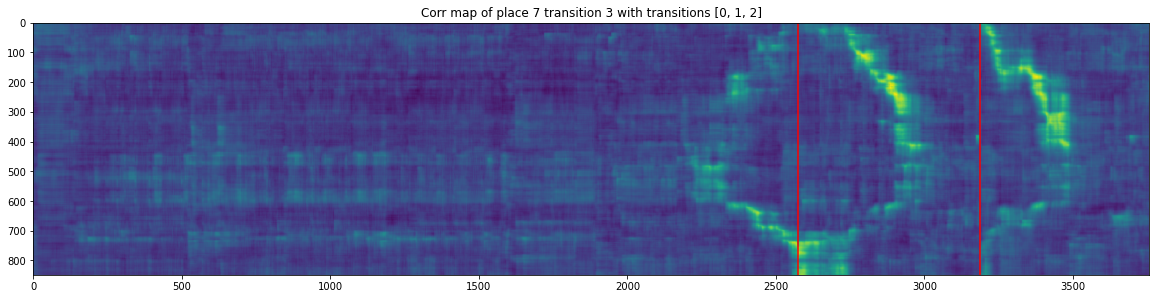

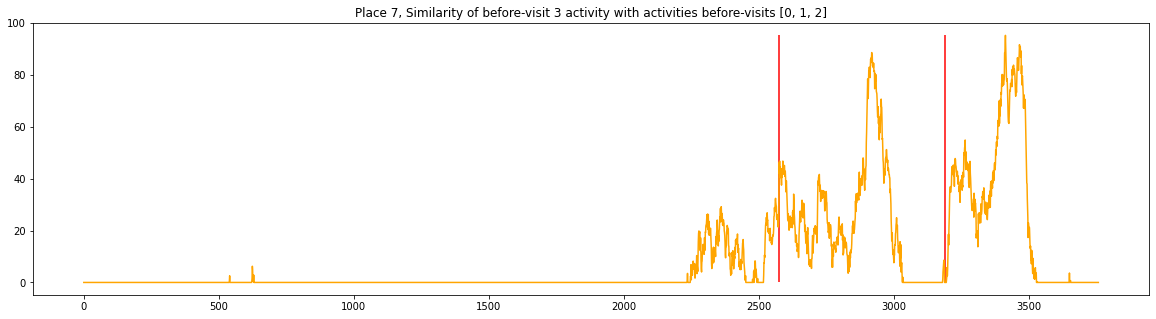

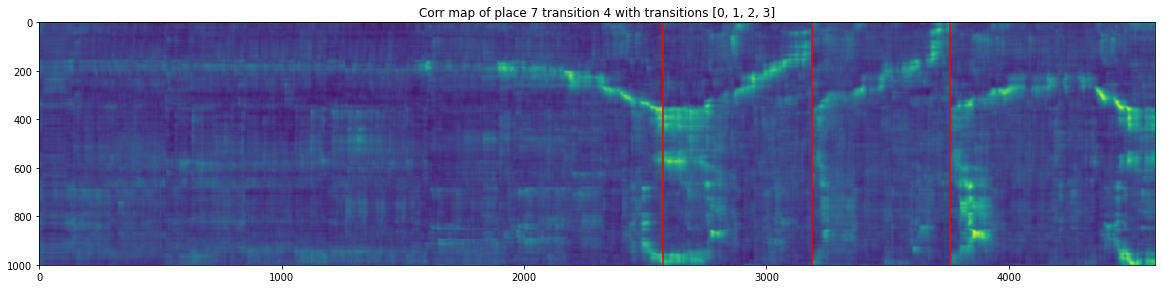

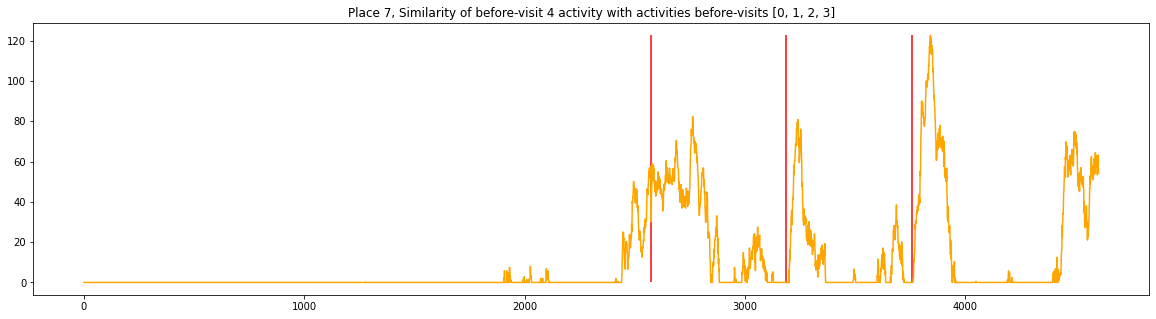

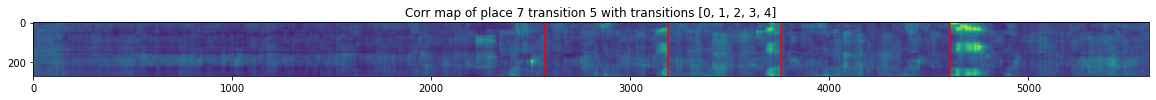

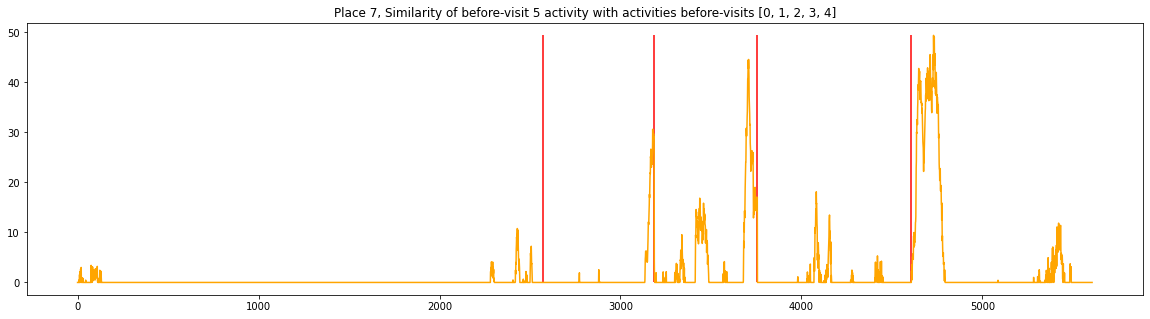

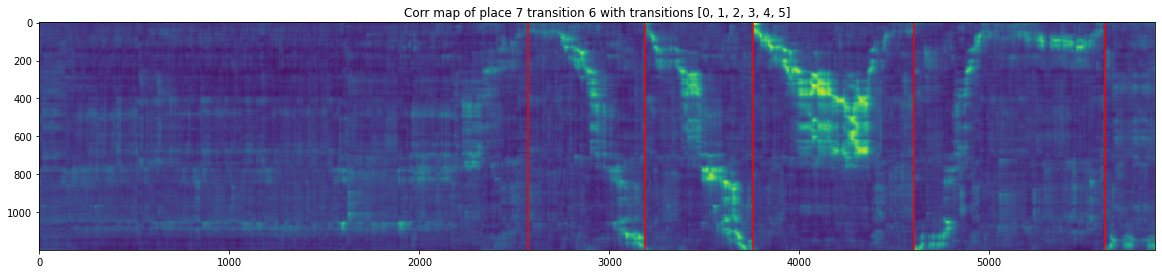

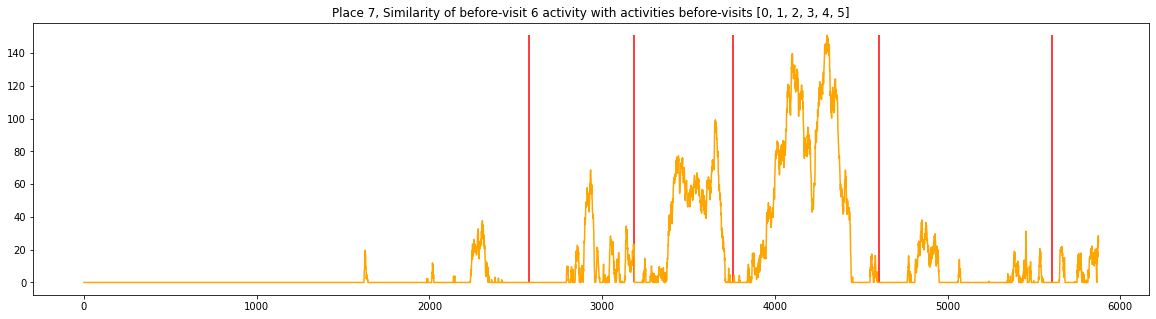

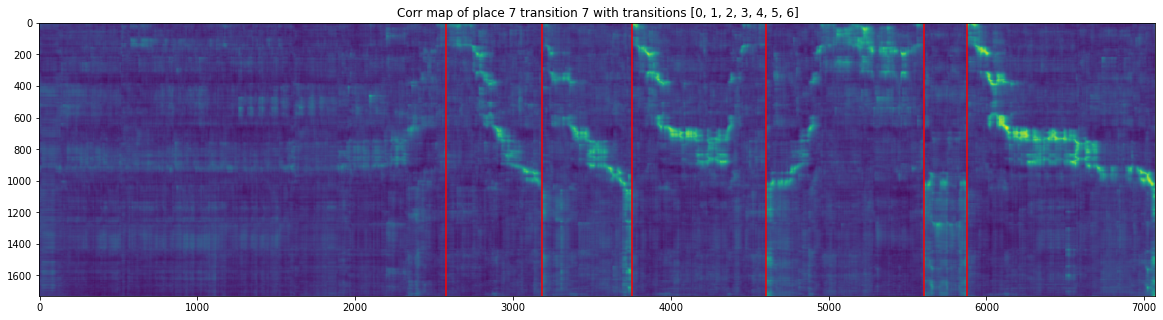

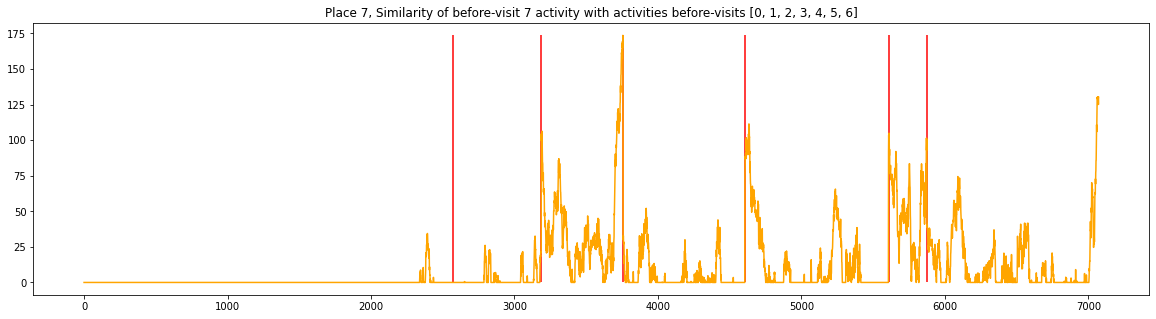

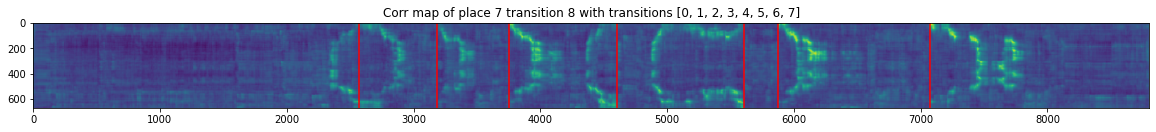

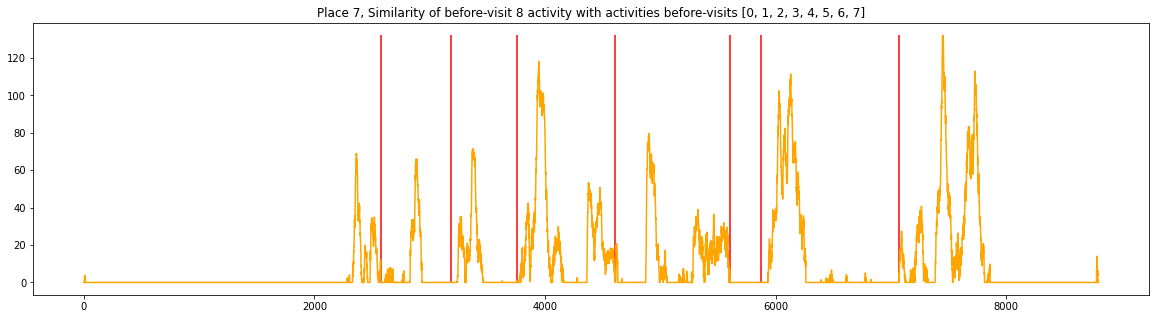

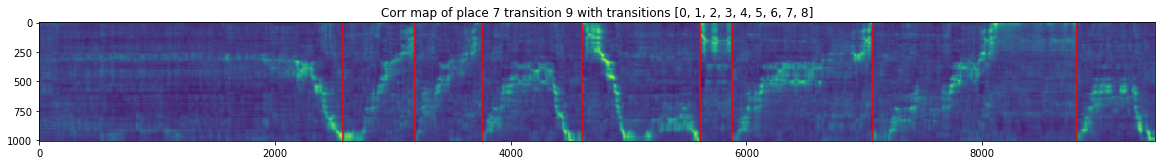

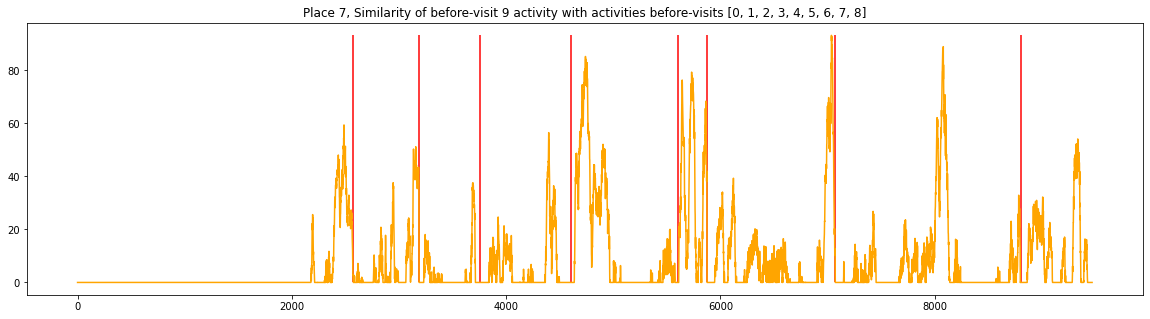

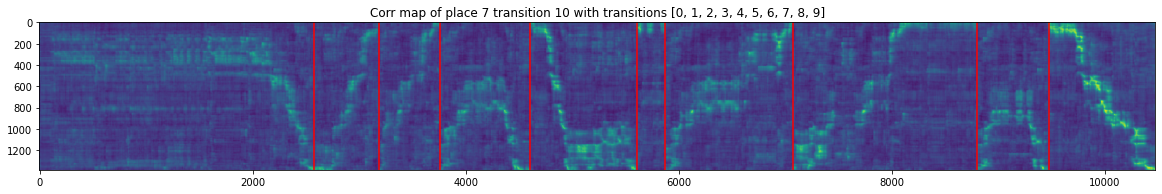

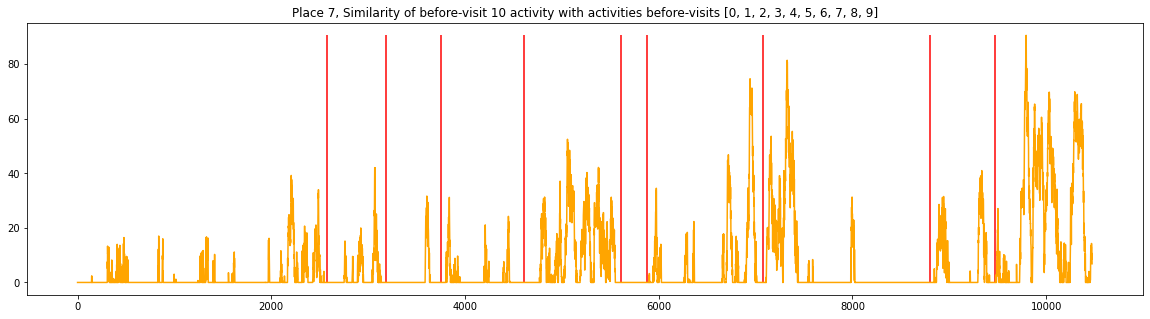

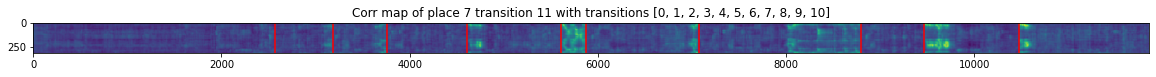

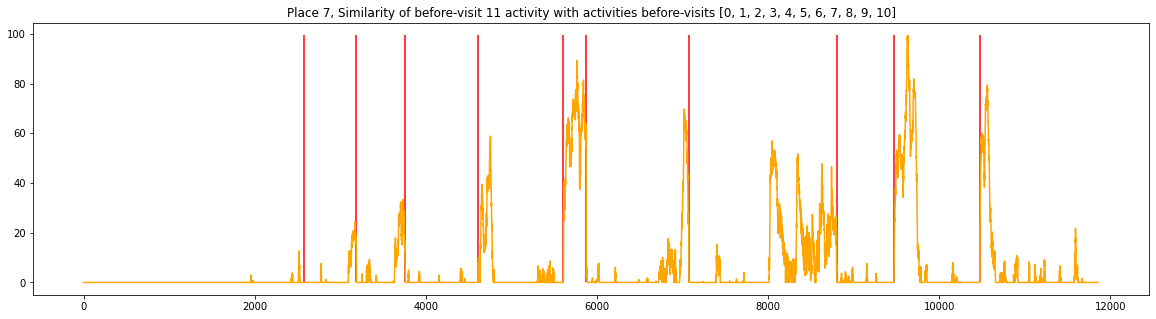

ValueError: Image size of 1440x77760 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1440x77760 with 1 Axes>

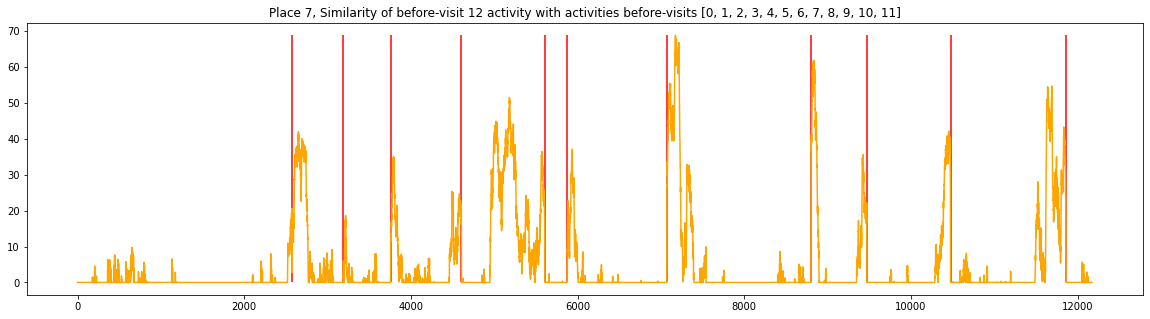

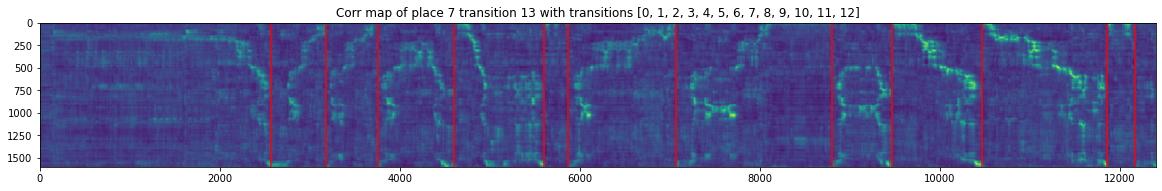

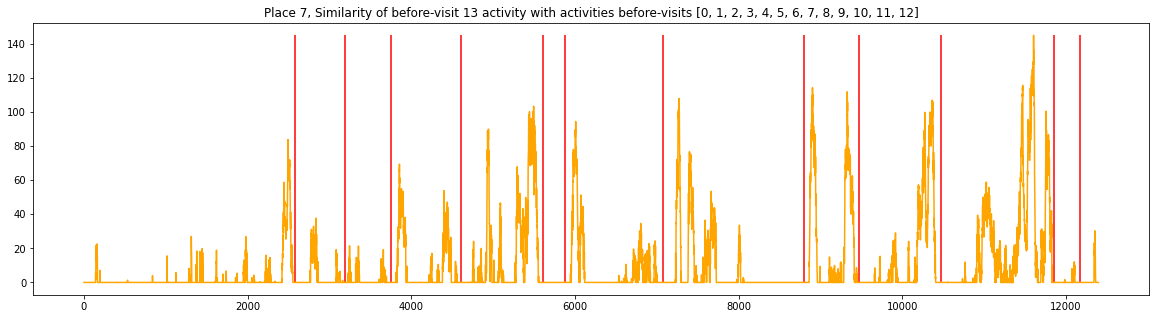

In [45]:
n_transitions = len(result['data_transition'])
for i in range(n_transitions):
    if i > 1:
        V_s = []
        for j in range(i):
            x1 = result['data_transition'][i]
            x2 = result['data_transition'][j]
            V = similarity_metric(x1,x2)
            V_s.append(V)
#             axes[j].imshow(V)
#             axes[j].set_title(f'Corr map of transitions {i} with {j}')
        V_all = np.concatenate(V_s, 1)
        h,w = V_all.shape
        plt.figure(figsize=(20,20*(w//h)))
        plt.imshow(V_all)
        plt.vlines(x=np.cumsum([V.shape[1] for V in V_s][:-1]),
                  ymin=1,
                  ymax=V_all.shape[0]-1,
                  color='r')
        plt.title(f'Corr map of place {place_number} transition {i} with transitions {list(range(i))}')
        
        plt.figure(figsize=(20,5))
        similarity_level = V_all.sum(0)
        similarity_level[similarity_level < 0] = 0.
        plt.plot(similarity_level, color='orange')
        plt.vlines(x=np.cumsum([V.shape[1] for V in V_s][:-1]),
                  ymin=0,
                  ymax=similarity_level.max(),
                  color='r')
        plt.title(f'Place {place_number}, Similarity of before-visit {i} activity with activities before-visits {list(range(i))}')
plt.show()